In [139]:
import sys, os, re, csv, codecs, numpy as np, pandas as pd
import keras
import tensorflow as tf

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation,Conv1D,Flatten
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split

In [55]:
train = pd.read_csv('/content/drive/My Drive/Module 3/Project/database/topic_identification_data.csv')

In [83]:
train.head()

,comment_text,obscenity,violence,verbal_abuse,identity_hate,hate,offense,neither
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,1
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,1
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,1
3,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,1
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,1


In [57]:
#preprocessing 
train['comment_text'].fillna('fillna')
x_train=train['comment_text'].str.lower()
y_train=train[[ "obscenity", "violence", "verbal_abuse", "identity_hate","hate","offense","neither"]].values

In [36]:
#embedding layer 
embed_size=100
max_features=20000
max_len=100

In [37]:
#process the traiing set
tokenizer= Tokenizer(num_words=max_features,lower= True)
tokenizer.fit_on_texts(list(x_train))
tokenized_train=tokenizer.texts_to_sequences(x_train)
train_x=pad_sequences(tokenized_train,maxlen=max_len)

In [38]:
batch_size=128
epochs = 2

In [41]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

In [85]:
# BEST MODEL with 88 % of accuracy 
inp = Input(shape=(max_len,))
x = Embedding(max_features, embed_size)(inp)
x = LSTM(50, return_sequences=True)(x)
x = GlobalMaxPool1D()(x)
x = Dropout(0.1)(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(7, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

In [86]:
history = model.fit(train_x,y_train,epochs=epochs,batch_size=batch_size,validation_split=0.1)

Epoch 1/2
1297/1297 [==============================] - 173s 134ms/step - loss: 0.4475 - accuracy: 0.9177 - val_loss: 1.4217 - val_accuracy: 0.3796
Epoch 2/2
1297/1297 [==============================] - 177s 137ms/step - loss: 0.2371 - accuracy: 0.9520 - val_loss: 0.4868 - val_accuracy: 0.8802


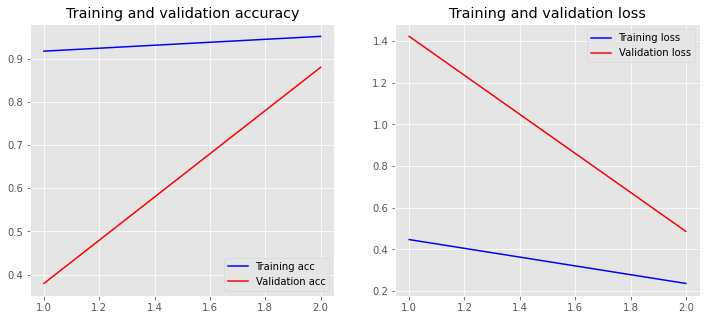

In [87]:
plot_history(history)

In [137]:
# save the model 
model.save('/content/drive/My Drive/Module 3/Project/database/topic_identifier_model.h5')

In [131]:
#test with a sentence
x_test = "you gay boy"

#preprocess the sentence
def preprocess_test(x_test):
  """ this function allows to preprocess the test sentence

      params : 
      x_test (string) : the test message

      return :
      test_x (vector) : the processed test message 
  """
  x_test = x_test.lower()
  x_test = [x_test]
  tokenized_test=tokenizer.texts_to_sequences(x_test)
  test_x=pad_sequences(tokenized_test,maxlen=max_len)

  return test_x

In [140]:
# load the model 
topic_identifier_model =  tf.keras.models.load_model('/content/drive/My Drive/Module 3/Project/database/topic_identifier_model.h5')

In [141]:
#predict the topic 
y_pred=topic_identifier_model.predict(preprocess_test(x_test))

In [142]:
y_pred

array([[0.20238304, 0.04775229, 0.2887668 , 0.07659307, 0.05820435,
        0.07535237, 0.24894503]], dtype=float32)

In [134]:
label_dict = {0: "obscenity", 1: "violence", 2: "verbal abuse", 3: "identity hate crime", 4: "hate crime", 5: "offense", 6:"neither"}

In [135]:
#get the prediction 
if y_pred.argmax(1)[0] != 6 : 
  # if the tweet contains sensitive topics 
  print("your tweet may contain sentences that present " + label_dict[y_pred.argmax(1)[0]]+ " with  "+str(y_pred[0][y_pred.argmax(1)[0]]*100) +" of confidence")

your tweet may contain sentences that present verbal abuse with  28.87668013572693 of confidence
